# WaveNet

## Notes
- **Plot the average loss accross steps:**
  - Instead of plotting the loss directly, it is often more useful to plot the average loss over multiple steps since this eliminates the noise due to minibatches. 
  - This can be achieved as follows: `plt.plot(torch.tensor(lossi).view(-1, 1000).mean(dim=1));`.
- **PyTorch-ification:**
  - The modules that we have implemented are very similar to `torch.nn` which is a neural networks API that is built ontop of `torch.tensor`.
  - Each layer can be wrapped up in a PyTorch style `nn.Module` container with the following methods: `__init__`, `__call__`, and `parameters`.
  - The layers can be stacked with a Pytorch style `nn.Sequential` container, which sequentially calls a list of layers. This allows us to wrap the whole network in a single container.
- **Matrix multiplication of higher order tensors:**
  - The matrix multiplication operation in PyTorch is quite powerful, and works with higher order tensors as well (not just matrices). The matrix multiplication acts only on the last dimension (and all the other dimensions remain unchanged). This is effectively like **adding more batch dimensions**.
  - E.g `(4, 5, 80) @ (80, 200) + (200,) = (4, 5, 200)`; where `(4, 5, 80)` is the input to the layer, `(80, 200)` are the weights, `(200,)` is the bias, and `(4, 5, 80)` is the output of the layer. In this example, the dimensions at index 0 and 1 are treated as batch dimensions, and the matrix multiplication acts on dimension 2.
- **Convolutions in the original WaveNet paper:**
  - The original WaveNet paper uses **convolutions over a single training sequence** to make training more **efficient** (in our case this is a single name from the training set). The network is convolved with the training sequence so that the overlapping outputs of the intermediate layers can be reused and the GPU can perform calculations in paralell. 
  - See *figure 3* from the [original wavenet paper](https://arxiv.org/pdf/1609.03499.pdf) (this is what we implemented).
  - What we have implemented is a heirachical neural network.
- **Development process:**
  - The development process of neural networks usually involves lots of reading of the PyTorch documentation, especiallly about dimension sizes and implementation details. Note that the documentation is is sometimes inaccurate.
  - There's a lot of stuff to do with shapes of tensors. It is often helpful to develop in a jupyter notebook, and then move the code over to python files to do experimentation.
  - Normally you look at the training and validation loss together and optimize on hyperparameters. This involves hyperparameter searches, python scripts with lots of arguments, lots of running experiments, looking at lots of plots, etc. all to see what works well and what doesn't.
  - In other words you would be working on the **population level** and this is what's referred to as a **training harness**. Setting this up and making it work well is a whole other topic.

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random

In [2]:
torch.set_printoptions(linewidth=140)

In [3]:
words = open("names.txt", "r").read().splitlines()
print(f"First few words: {words[:5]}\nNumber of words: {len(words)}")

First few words: ['emma', 'olivia', 'ava', 'isabella', 'sophia']
Number of words: 32033


In [4]:
chars = ["."] + sorted(set("".join(words)))
char_to_ix = {s: i for i, s in enumerate(chars)}
ix_to_char = {i: s for s, i in char_to_ix.items()}
vocab_size = len(chars)

In [5]:
block_size = 6

In [6]:
def build_dataset(words, block_size=3, verbose=False):
  X, Y = [], []
  for word in words:
    padded_word = ["."] * block_size + list(word) + ["."]
    for i in range(len(padded_word)-block_size):
      context = [char_to_ix[char] for char in padded_word[i:i+block_size]]
      target = char_to_ix[padded_word[i+block_size]]
      X.append(context)
      Y.append(target)
  X, Y = torch.tensor(X), torch.tensor(Y)
  if verbose:
    print(f"{X.shape}\t{Y.shape}")
  return X, Y

In [7]:
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

In [8]:
X_train, Y_train = build_dataset(words[:n1], block_size=block_size, verbose=True)
X_dev, Y_dev = build_dataset(words[n1:n2], block_size=block_size, verbose=True)
X_test, Y_test = build_dataset(words[n2:], block_size=block_size, verbose=True)

torch.Size([182625, 6])	torch.Size([182625])
torch.Size([22655, 6])	torch.Size([22655])
torch.Size([22866, 6])	torch.Size([22866])


In [9]:
for x, y in zip(X_train[:10], Y_train[:10]):
  print(''.join(ix_to_char[int(ix.item())] for ix in x), '-->', ix_to_char[int(y.item())])

...... --> y
.....y --> u
....yu --> h
...yuh --> e
..yuhe --> n
.yuhen --> g
yuheng --> .
...... --> d
.....d --> i
....di --> o


In [11]:
class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # note: kaiming init
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      # note this is different from PyTorch which expects the sequence dimension to be in the middle
      if x.ndim == 3:
        dim = (0,1) # since we want to calculate the mean across all "batch" dimensions
      else:
        dim = 0 # default batch dimension is just 0
      xmean = x.mean(dim, keepdim=True) # batch mean
      xvar = x.var(dim, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]


class Tanh:
  
  def __init__(self):
    pass
  
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out

  def parameters(self):
    return []


class Embedding:
  
  def __init__(self, num_embeddings, embedding_dim):
    self.weights = torch.randn((num_embeddings, embedding_dim))
  
  def __call__(self, IX):
    self.out = self.weights[IX]
    return self.out
  
  def parameters(self):
    return [self.weights]


class Flatten:
  
  def __init__(self):
    pass
  
  def __call__(self, x):
    self.out = x.view(x.shape[0], -1) # maintain the batch dimension
    return self.out
  
  def parameters(self):
    return []


class FlattenConsecutive:
  
  def __init__(self, n): # n is the number of elements (that are conesecutive) that we want to concatenate in the last dimension
    self.n = n
  
  def __call__(self, x):
    B, T, C = x.shape
    x = x.view(B, -1, C*self.n) # -1 will end up being T//n
    if x.shape[1] == 1:
      x = x.squeeze(dim=1)
    self.out = x
    return self.out
  
  def parameters(self):
    return []


# Holds a list of layers. See PyTorch containers.
class Sequential:
  
  def __init__(self, layers):
    self.layers = layers
    
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [12]:
torch.manual_seed(42);

In [13]:
embedding_dim = 10
hidden_layer_size = 128

model = Sequential([
  Embedding(vocab_size, embedding_dim), # (B, T) -> (B, T, E)
  FlattenConsecutive(n=3), # (B, T, E) -> (B, T/3, E*3)
  Linear(3*embedding_dim, hidden_layer_size, bias=False), BatchNorm1d(hidden_layer_size), Tanh(), # (B, T/3, E*3) -> (B, T/3, H)
  FlattenConsecutive(n=2), # (B, T/3, H) -> (B, T/6, H*2) Note: T/6 is 1 so this dimension might as well be removed
  Linear(2*hidden_layer_size, hidden_layer_size, bias=False), BatchNorm1d(hidden_layer_size), Tanh(), # (B, T/6, H*2) -> (B, T/6, H)
  Linear(hidden_layer_size, vocab_size, bias=True) # (B, T/6, H) -> (B, T/6, V)
])

with torch.no_grad():
  model.layers[-1].weight *= 0.1 # make the last layer less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad = True

40873


In [14]:
# example forward pass with a batch of size 4
Xb = X_train[torch.randint(0, X_train.shape[0], (4,))] # batch of size 4
model(Xb)
for layer in model.layers:
  print(f"{layer.__class__.__name__}: {tuple(layer.out.shape)}")

Embedding: (4, 6, 10)
FlattenConsecutive: (4, 2, 30)
Linear: (4, 2, 128)
BatchNorm1d: (4, 2, 128)
Tanh: (4, 2, 128)
FlattenConsecutive: (4, 256)
Linear: (4, 128)
BatchNorm1d: (4, 128)
Tanh: (4, 128)
Linear: (4, 27)


In [15]:
for layer in model.layers:
    layer.training = True

max_steps = 200_000
batch_size = 32
lossi = []

for step in range(max_steps):
  
  # minibatch construct
  ixs = torch.randint(0, X_train.shape[0], (batch_size,))
  Xb, Yb = X_train[ixs], Y_train[ixs]
  
  # forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb)
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update: simple SGD
  lr = 0.1 if step < 150_000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad # type: ignore
  
  # track stats
  if step % 10_000 == 0:
    print(f"{step}/{max_steps}\t{loss.item():.4f}")
  lossi.append(loss.item())

0/200000	3.2940
10000/200000	1.9453
20000/200000	2.1717
30000/200000	2.0949
40000/200000	1.8160
50000/200000	2.0289
60000/200000	1.7016
70000/200000	2.2403
80000/200000	1.6098
90000/200000	2.0955
100000/200000	1.9176
110000/200000	2.5653
120000/200000	2.2417
130000/200000	1.7494
140000/200000	1.7649
150000/200000	2.0008
160000/200000	2.3250
170000/200000	1.7746
180000/200000	2.0487
190000/200000	2.1251


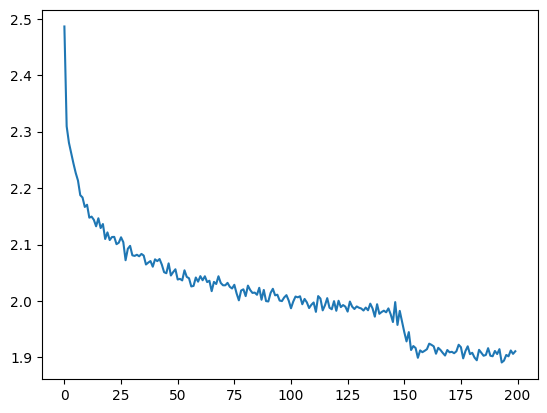

In [16]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(dim=1));

In [17]:
@torch.no_grad() # disables gradient tracking
def evaluate(X, Y):
    for layer in model.layers:
        layer.training = False
    logits = model(X)
    loss = F.cross_entropy(logits, Y)
    return loss.item()

In [18]:
print(f"Training split loss: {evaluate(X_train, Y_train):.4f}")
print(f"Development split loss: {evaluate(X_dev, Y_dev):.4f}")

Training split loss: 1.8660
Development split loss: 2.0028


In [19]:
print(f"Test split loss: {evaluate(X_test, Y_test):.4f}")

Test split loss: 1.9992


In [20]:
for layer in model.layers:
    layer.training = False
with torch.no_grad():
    g = torch.Generator().manual_seed(5)
    for _ in range(20):
        context = ["."] * block_size
        out = []
        while True:
            x = torch.tensor([[char_to_ix[char] for char in context]])
            logits = model(x)
            probs = F.softmax(logits, dim=1)
            ix = torch.multinomial(probs, num_samples=1, generator=g).item()
            if ix==0:
                break
            char = ix_to_char[ix] # type: ignore
            context = context[1:] + [char]
            out.append(char)
        print("".join(out), end="\n")

karyus
kimba
esma
gamilie
shrith
gilyfe
alainna
paysa
meda
miccen
aryshelled
jourdan
elnoe
kiodec
shan
aashta
rless
novay
brookle
zakhini
